In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
business = pd.read_csv('/content/drive/MyDrive/YelpRecommender/Data/NewOrleans/business.csv',index_col=[0])
review = pd.read_csv('/content/drive/MyDrive/YelpRecommender/Data/NewOrleans/review.csv',index_col=[0])

In [ ]:
# Before working on the model let's split the data between test, train and validation data

# Now in the recommendation system We must design a train-test split where there are no new users
# or new businesses in the test set because the content-based recommendation ranking only functions
# with current customers and restaurants.

# Therefore we will use holdout method to achieve this.

In [ ]:
review.columns

Index(['date', 'user_id', 'useful', 'cool', 'text', 'funny', 'review_id',
       'business_id', 'stars'],
      dtype='object')

In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539474 entries, 0 to 539473
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         539474 non-null  object 
 1   user_id      539474 non-null  object 
 2   useful       539474 non-null  int64  
 3   cool         539474 non-null  int64  
 4   text         539474 non-null  object 
 5   funny        539474 non-null  int64  
 6   review_id    539474 non-null  object 
 7   business_id  539474 non-null  object 
 8   stars        539474 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 41.2+ MB


In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 65 to 150251
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   state                                  3306 non-null   object 
 1   attributes.RestaurantsPriceRange2      2748 non-null   float64
 2   attributes.RestaurantsCounterService   1 non-null      object 
 3   attributes.DietaryRestrictions         1 non-null      object 
 4   attributes.BestNights                  501 non-null    object 
 5   attributes.HairSpecializesIn           0 non-null      float64
 6   attributes.Ambience                    2215 non-null   object 
 7   attributes.NoiseLevel                  1949 non-null   object 
 8   attributes.Smoking                     351 non-null    object 
 9   attributes.GoodForMeal                 1369 non-null   object 
 10  hours.Tuesday                          2274 non-null   object 
 11  a

In [4]:
def remove_punctuations(text):
  import string
  nopunc = [char for char in text if char not in string.punctuation]
  return ''.join(nopunc)

In [5]:
review['text'] = review['text'].apply(remove_punctuations)

In [ ]:
#stratify cannot be an option, as equal proportion is not required rather random shuffling is required.


In [6]:
np.random.seed(42)
idx = np.array(review.index)
np.random.shuffle(idx)

In [7]:
train = review.loc[idx[:int(0.85*len(idx))]]
test = review.loc[idx[int(0.85*len(idx)):]]

In [ ]:
# Now let's check which reviews of user_id are there in test but not in train and send them back to train

In [8]:
test_only_userid = test[-test.user_id.isin(train.user_id.unique())]
len(test_only_userid)

21083

In [9]:
ids_test_only = test_only_userid['user_id'].drop_duplicates().index

In [10]:
train_all_idx = train.index.union(ids_test_only)
test_all_idx = review.index.difference(train_all_idx)

In [11]:
train = review.loc[train_all_idx]
test = review.loc[test_all_idx]

In [ ]:
len(train)/(len(train)+len(test))

0.8873550903287276

In [ ]:
len(test)/(len(train)+len(test))

0.11264490967127239

In [ ]:
# train vs test ratio now becomes 89:11

In [ ]:
set(test.business_id) - set(train.business_id)

set()

In [ ]:
# There are no businesses in test which are unique and not present in train 
# so we do not need to modify our train and test

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478705 entries, 0 to 539473
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         478705 non-null  object 
 1   user_id      478705 non-null  object 
 2   useful       478705 non-null  int64  
 3   cool         478705 non-null  int64  
 4   text         478705 non-null  object 
 5   funny        478705 non-null  int64  
 6   review_id    478705 non-null  object 
 7   business_id  478705 non-null  object 
 8   stars        478705 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 36.5+ MB


In [ ]:
train.groupby('business_id')['text'].count().sort_values(ascending=False)


business_id
ac1AeYqs8Z4_e2X5M3if2A    6856
_ab50qdWOk0DdB6XOrBitw    6724
oBNrLz4EDhiscSlbOl8uAw    4685
iSRTaT9WngzB8JJ2YKJUig    4662
VQcCL9PiNL_wkGf-uF3fjg    4626
                          ... 
RatJCtQ8j4cG80vAPr9UAw       3
SgCU0hvmsSbY6uL3lmjJ6A       3
h9Qf7cOTUdzufvoRxWIFoA       2
4QdZHOqo7OI63SG6JnLdpg       2
moT5dbsX7v6aZgJcwDZrgw       2
Name: text, Length: 3306, dtype: int64

In [ ]:
# let's analyse the same business review together

In [ ]:
# Rather than joining them directly adding a seperator will be wise as to seperate later if required.

In [12]:
rev_by_business = train.groupby('business_id').agg({'review_id':'count', 'text':lambda x: '****'.join(x)})
rev_by_business = rev_by_business.rename(columns = {'review_id':'review_count','text':'all_reviews'})

In [13]:
rev_by_business = rev_by_business.reset_index()

In [14]:
rev_by_business.head()

,business_id,review_count,all_reviews
0,--x_BmZbxzK_nx_GHBaRVw,18,We lucked out and the other people for the tou...
1,--zb12mw2YK-7j6UaHzm8w,11,Billy Wrights Manuels Style Hot Tamales are de...
2,-0__F9fnKt8uioCKztF5Ww,47,Great location and the rooftop lounge area of ...
3,-0ltw8--HLuulPyOSspqAQ,9,My daughter and her family stayed here for the...
4,-1XSzguS6XLN-V6MVZMg2A,480,Hands down this is my NEW favorite restaurant ...


In [15]:
train.groupby('user_id')['text'].count().sort_values(ascending=False)


user_id
Xw7ZjaGfr0WNVt6s_5KZfA    833
0Igx-a1wAstiBDerGxXk2A    802
1HM81n6n4iPIFU5d2Lokhw    791
CfX4sTIFFNaRchNswqhVfg    652
E4BsVQnG5zetbwv2x8QIWg    596
                         ... 
OoSq-eZzHDHJ15VGxvYadg      1
OoU5rUVSg4tU0XkYllbQ6g      1
OoUKiMGbN5CW6QHDe2haTw      1
OoWcmDbuPcUwUDYgiKtC6A      1
zzxZoMmjbUjXcWZzrE3PIw      1
Name: text, Length: 214512, dtype: int64

In [16]:
yelp_data = train[['review_id', 'user_id', 'business_id', 'text', 'stars', 'date']]

In [ ]:
review = None

In [17]:
rev_by_user = train.groupby('user_id').agg({'review_id':'count', 'text':lambda x: '****'.join(x)})
rev_by_user = rev_by_user.rename(columns = {'review_id':'review_count','text':'all_reviews'})

In [18]:
rev_by_user = rev_by_user.reset_index()

In [19]:
rev_by_user = rev_by_user[:8000]

In [20]:
rev_by_user.head()

,user_id,review_count,all_reviews
0,---UgP94gokyCDuB5zUssA,4,Overall Great food with a few minor hiccups It...
1,--1orhUoGFSdHXsoxqQc8g,1,Absolutely the worst customer service ever 4 p...
2,--3PldvWEZ_bhLNsyrAtgA,1,Great bbq I had the pulled pork sandwich with ...
3,--3WaS23LcIXtxyFULJHTA,1,Killer Poboys is not your average Poboy spot T...
4,--48iehfEvtnSrLq8grJIQ,4,Great bartender Try a Ramos fizz they take a f...


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
rev_by_business.loc[:0.01*len(rev_by_business)]['all_reviews']

0     We lucked out and the other people for the tou...
1     Billy Wrights Manuels Style Hot Tamales are de...
2     Great location and the rooftop lounge area of ...
3     My daughter and her family stayed here for the...
4     Hands down this is my NEW favorite restaurant ...
5     Dont even wast your time very slow always out ...
6     Completely disappointed with how this location...
7     Dont be fooled by the exterior this place is a...
8     NASTY NASTY NASTY Steer clear  Ive been told t...
9     OMG So its too bad they only allow 5 stars as ...
10    This Snowball Shop is now in my Top Favorites ...
11    Yes I love this place Maple Street Patisserie ...
12    If youre looking for a great apple fritter GET...
13    If you ever travel from New Orleans to Slidell...
14    VERY good food I get take out for lunch and yo...
15    Krewe of Carrollton was a pretty fun parade\n\...
16    Their store is on Grubhub but doesnt work on G...
17    Horriblethey dont care about their custome

In [23]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=5000)
X = vectorizer.fit_transform(rev_by_business.loc[:0.01*len(rev_by_business)].all_reviews)
print(vectorizer.get_feature_names_out()[:100])

['050' '050 oysters' '10' '10 minutes' '100' '1000' '1010' '10pm' '11'
 '12' '13' '14' '15' '15 minutes' '150' '16' '17' '18' '19' '1pm' '1st'
 '1st time' '20' '20 minutes' '21' '23' '24' '25' '25 minutes' '2nd' '30'
 '30 min' '30 minutes' '300' '34' '35' '35 stars' '3rd' '40' '40 minutes'
 '400' '45' '45 minutes' '45 stars' '4630' '50' '50 cent'
 '50 cent oysters' '50 cent raw' '50 cents' '50 cents oysters' '500' '55'
 '600' '630' '630pm' '700' '730' '75' '75s' '830' '90' 'ability' 'abita'
 'able' 'able try' 'absinthe' 'absinthe bar' 'absinthe drinks' 'absolute'
 'absolute best' 'absolute favorite' 'absolutely' 'absolutely amazing'
 'absolutely best' 'absolutely delicious' 'absolutely fantastic'
 'absolutely love' 'absolutely loved' 'absolutely wonderful' 'ac' 'accept'
 'acceptable' 'accident' 'accidentally' 'accommodate' 'accommodated'
 'accommodating' 'accompanied' 'accompanying' 'according' 'acme' 'act'
 'acted' 'actual' 'actually' 'add' 'added' 'added nice' 'adding']
CPU times: us

In [ ]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=5000)
X = vectorizer.fit_transform(rev_by_business.loc[:0.1*len(rev_by_business)].all_reviews)
print(vectorizer.get_feature_names_out()[:100])

['10' '10 minutes' '100' '1000' '1010' '1015' '11' '12' '13' '14' '15'
 '15 minutes' '150' '16' '17' '18' '19' '1st' '20' '20 minutes' '20 years'
 '200' '2016' '2017' '2018' '21' '23' '24' '24 hours' '247' '25' '25 cent'
 '25 minutes' '250' '2nd' '30' '30 minutes' '300' '34' '35' '35 stars'
 '3rd' '40' '40 minutes' '400' '45' '45 minutes' '45 stars' '4th' '50'
 '50 cent' '55' '60' '6pm' '75' '80' '8pm' '90' 'abita' 'able' 'absinthe'
 'absinthe house' 'absolute' 'absolute best' 'absolute favorite'
 'absolutely' 'absolutely amazing' 'absolutely delicious'
 'absolutely love' 'absolutely loved' 'ac' 'accept' 'acceptable' 'access'
 'accessible' 'accident' 'accidentally' 'accommodate' 'accommodating'
 'accompanied' 'according' 'account' 'accurate' 'acknowledge'
 'acknowledged' 'act' 'acted' 'action' 'actual' 'actually'
 'actually pretty' 'add' 'added' 'adding' 'addition' 'additional'
 'additionally' 'address' 'adds' 'adequate']
CPU times: user 21.3 s, sys: 897 ms, total: 22.2 s
Wall time: 23

In [24]:
%%time
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=1000)
X = vectorizer.fit_transform(rev_by_business.all_reviews)
# print(vectorizer.get_feature_names_out()[:100])

CPU times: user 1min 42s, sys: 2.35 s, total: 1min 44s
Wall time: 1min 44s


In [ ]:
%%time
vectorizer2 = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=1000)
X2 = vectorizer2.fit_transform(rev_by_user.loc[:0.1*len(rev_by_user)].all_reviews)

CPU times: user 14.2 s, sys: 153 ms, total: 14.3 s
Wall time: 14.4 s


In [25]:
%%time
vectorizer2 = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=1000)
X2 = vectorizer2.fit_transform(rev_by_user.all_reviews)

CPU times: user 4.89 s, sys: 41.8 ms, total: 4.94 s
Wall time: 4.91 s


In [ ]:
X[:10]

<10x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 4761 stored elements in Compressed Sparse Row format>

In [26]:
# Convert sparse matrix to dataframe
business_review_features = pd.DataFrame.sparse.from_spmatrix(X)
business_review_features = business_review_features.set_index(rev_by_business.business_id)
# business_review_features.head()
user_review_features = pd.DataFrame.sparse.from_spmatrix(X2)
user_review_features = user_review_features.set_index(rev_by_user.user_id)

In [ ]:
business_review_features.shape # there are 3306 businesses and their features.

(3306, 1000)

In [ ]:
user_review_features.shape

(8000, 1000)

In [ ]:
len(vectorizer.get_feature_names_out())

5000

In [ ]:
len(vectorizer2.get_feature_names_out())

5000

In [ ]:
type(vectorizer.get_feature_names_out()[0])

str

In [27]:
business_review_features.columns = vectorizer.get_feature_names_out()
user_review_features.columns = vectorizer2.get_feature_names_out()

In [ ]:
business_review_features.head()

,10,10 minutes,12,15,15 minutes,20,20 minutes,25,30,30 minutes,...,wrong,year,years,yelp,yes,youll,young,youre,yum,yummy
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,0.018018,0.000000,0.011011,0.000000,0.000000,0.000000,0.000000,0.012841,0.010979,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010401,0.011777,0.016032,0.000000,0.000000
--zb12mw2YK-7j6UaHzm8w,0.030198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031495,0.034938,0.000000,0.000000,0.039478,0.000000,0.000000,0.000000
-0__F9fnKt8uioCKztF5Ww,0.008827,0.000000,0.021577,0.010454,0.013082,0.010014,0.013245,0.000000,0.010757,0.013316,...,0.037845,0.020309,0.000000,0.030636,0.019383,0.020381,0.011539,0.039269,0.000000,0.010335
-0ltw8--HLuulPyOSspqAQ,0.030681,0.000000,0.037500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031999,0.000000,0.067376,0.070843,0.000000,0.109198,0.043351,0.000000
-1XSzguS6XLN-V6MVZMg2A,0.010250,0.004571,0.008674,0.002802,0.001169,0.001789,0.000000,0.002248,0.003844,0.001189,...,0.011833,0.007257,0.011513,0.025543,0.006926,0.006372,0.003092,0.013330,0.005570,0.006463


In [ ]:
user_review_features.head()

,10,10 minutes,100,12,15,20,25,30,30 minutes,45,...,yeah,year,years,yelp,yes,youll,youre,youve,yum,yummy
user_id,,,,,,,,,,,,,,,,,,,,,
---UgP94gokyCDuB5zUssA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.102680,0.0,0.0,0.0,0.000000,0.0
--1orhUoGFSdHXsoxqQc8g,0.126445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
--3PldvWEZ_bhLNsyrAtgA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
--3WaS23LcIXtxyFULJHTA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.103302,0.0,0.0,0.0,0.000000,0.0
--48iehfEvtnSrLq8grJIQ,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.118313,0.0


Feature Reduction using PCA

In [28]:
from sklearn.decomposition import PCA

In [ ]:
business_review_features.sparse.to_dense().head()

,10,10 minutes,12,15,15 minutes,20,20 minutes,25,30,30 minutes,...,wrong,year,years,yelp,yes,youll,young,youre,yum,yummy
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,0.018018,0.000000,0.011011,0.000000,0.000000,0.000000,0.000000,0.012841,0.010979,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010401,0.011777,0.016032,0.000000,0.000000
--zb12mw2YK-7j6UaHzm8w,0.030198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031495,0.034938,0.000000,0.000000,0.039478,0.000000,0.000000,0.000000
-0__F9fnKt8uioCKztF5Ww,0.008827,0.000000,0.021577,0.010454,0.013082,0.010014,0.013245,0.000000,0.010757,0.013316,...,0.037845,0.020309,0.000000,0.030636,0.019383,0.020381,0.011539,0.039269,0.000000,0.010335
-0ltw8--HLuulPyOSspqAQ,0.030681,0.000000,0.037500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031999,0.000000,0.067376,0.070843,0.000000,0.109198,0.043351,0.000000
-1XSzguS6XLN-V6MVZMg2A,0.010250,0.004571,0.008674,0.002802,0.001169,0.001789,0.000000,0.002248,0.003844,0.001189,...,0.011833,0.007257,0.011513,0.025543,0.006926,0.006372,0.003092,0.013330,0.005570,0.006463


In [29]:
%%time
# PCA for dimentionality reduction
pca = PCA()

business_pca_features = pca.fit_transform(business_review_features.sparse.to_dense())


CPU times: user 3.1 s, sys: 889 ms, total: 3.99 s
Wall time: 1.16 s


In [30]:
%%time
pca2 = PCA()
user_pca_features = pca2.fit_transform(user_review_features.sparse.to_dense())

CPU times: user 6.47 s, sys: 1.23 s, total: 7.69 s
Wall time: 2.57 s


In [ ]:
explained_variance_ratio = pca2.explained_variance_ratio_

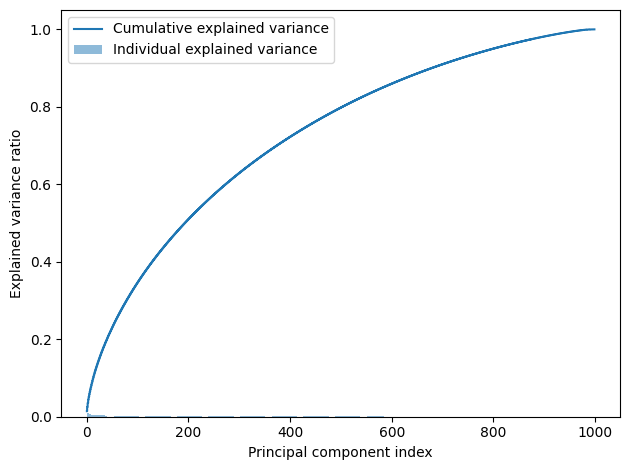

In [ ]:
cum_sum_eigenvalues = np.cumsum(explained_variance_ratio)
#
# Create the visualization plot
#
plt.bar(range(0,len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# import pickle
# with open('pca_business.pkl', 'wb') as pickle_file:
#         pickle.dump(pca, pickle_file)

In [ ]:
# import pickle
# with open('pca_user.pkl', 'wb') as pickle_file:
#         pickle.dump(pca2, pickle_file)

In [ ]:
import pickle
# reading and transforming data back
with open('/content/drive/MyDrive/YelpRecommender/Pickle_files/pca_business.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)


In [ ]:
business_pca_features = pca.transform(business_review_features.sparse.to_dense())

In [ ]:

# reading and transforming data back
with open('/content/drive/MyDrive/YelpRecommender/Pickle_files/pca_user.pkl', 'rb') as pickle_file:
    pca2 = pickle.load(pickle_file)

In [35]:
user_pca_features = pca2.transform(user_review_features.sparse.to_dense())

In [36]:
business_pcafeature = pd.DataFrame(business_pca_features[:,:700], index=business_review_features.index, columns=business_review_features.columns[:700])

In [37]:
business_pcafeature.head()

,10,10 minutes,12,15,15 minutes,20,20 minutes,25,30,30 minutes,...,problem,pudding,pulled,quality,quarter,quick,quickly,quiet,quite,raw
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,-0.289666,-0.109454,0.038489,-0.225291,0.238462,0.167396,0.016315,-0.114173,0.216055,-0.176475,...,0.001185,-0.008963,0.013055,0.008543,0.005727,0.010001,-0.004550,-0.004495,-0.000627,0.003261
--zb12mw2YK-7j6UaHzm8w,-0.093334,-0.120138,0.029334,-0.139521,0.058224,0.049186,-0.007548,0.044064,0.006012,-0.039793,...,-0.011567,-0.009014,-0.001737,-0.017612,0.007432,0.012585,-0.008752,0.013454,0.011889,0.007071
-0__F9fnKt8uioCKztF5Ww,-0.055225,0.414484,-0.023394,0.159493,-0.052941,-0.027068,0.071784,0.019985,0.058636,0.054918,...,-0.004411,0.000052,0.005578,-0.008204,0.000902,0.001048,0.013685,0.003261,0.005761,0.010545
-0ltw8--HLuulPyOSspqAQ,-0.054615,0.031138,-0.054414,0.015481,0.085246,-0.065940,-0.081257,-0.150943,0.127126,-0.036320,...,-0.004517,-0.001153,0.010079,0.003749,0.019530,0.001769,0.013370,0.014154,0.013973,0.001502
-1XSzguS6XLN-V6MVZMg2A,0.331914,0.097802,-0.030673,0.050489,0.302158,0.026223,0.022331,-0.008237,-0.003277,0.013162,...,-0.001754,-0.008100,-0.011732,-0.007020,-0.003695,-0.006958,-0.013920,0.004845,-0.001055,-0.000455


In [38]:
user_pcafeature = pd.DataFrame(user_pca_features[:,:700], index=user_review_features.index, columns=user_review_features.columns[:700])

In [ ]:
user_pcafeature.head()

,10,10 minutes,12,15,15 minutes,20,20 minutes,25,30,30 minutes,...,problem,pudding,pulled,quality,quarter,quick,quickly,quiet,quite,raw
user_id,,,,,,,,,,,,,,,,,,,,,
---UgP94gokyCDuB5zUssA,0.094065,0.040870,0.162685,-0.104346,-0.038085,-0.086335,0.128289,-0.064774,0.007596,0.058641,...,0.005378,-0.030319,-0.004612,0.005302,0.001644,0.014772,0.001630,0.044851,0.000561,0.007346
--1orhUoGFSdHXsoxqQc8g,-0.033576,-0.144209,-0.125955,-0.175405,-0.096753,-0.053990,-0.006892,-0.045978,0.021402,0.013359,...,0.004373,-0.012049,0.008483,0.017777,-0.003808,0.002198,0.000290,0.009645,0.011004,-0.016386
--3PldvWEZ_bhLNsyrAtgA,-0.133470,-0.026974,0.031271,0.123745,0.043058,-0.019202,-0.060739,-0.050810,-0.104223,-0.029632,...,-0.006913,0.002959,-0.010400,0.003991,-0.006382,-0.013472,-0.001735,0.001865,-0.009043,0.010415
--3WaS23LcIXtxyFULJHTA,0.051072,-0.056207,-0.013916,0.178079,0.017894,-0.033445,0.057950,0.037547,-0.000461,0.054534,...,-0.015562,0.001613,0.010853,0.000693,-0.008801,0.015330,0.001018,-0.003142,-0.004314,-0.018101
--48iehfEvtnSrLq8grJIQ,0.089724,-0.059780,0.030619,0.019685,0.073497,0.020418,-0.026287,-0.029321,-0.039727,0.021663,...,0.055523,-0.016201,0.006250,0.033273,0.046110,-0.033097,0.008766,-0.038172,0.055110,0.077490


In [39]:
userid_rating_matrix = pd.pivot_table(yelp_data, values='stars', index=['user_id'], columns=['business_id'])

In [40]:
userid_rating_matrix2 = userid_rating_matrix.loc[user_pcafeature.index]

In [41]:
userid_rating_matrix2.shape

(8000, 3306)

In [42]:
def matrix_factorization(R, P, Q, steps=25, gamma=0.001,lamda=0.02):
    for step in range(steps):
        print(step)
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        print("Step Completed")
    return P,Q

In [43]:
%%time
user_pcafeature,business_pcafeature = matrix_factorization(userid_rating_matrix2,user_pcafeature,business_pcafeature)

0


KeyboardInterrupt: ignored

In [ ]:
# Store P, Q and vectorizer in pickle file
import pickle
output = open('content_based_recommender.pkl', 'wb')
pickle.dump(user_pcafeature,output)
pickle.dump(business_pcafeature,output)
pickle.dump(vectorizer2,output)
output.close()

In [49]:
import pickle
with open('/content/drive/MyDrive/YelpRecommender/Pickle_files/content_based_recommender.pkl', 'rb') as file:
    user_pcafeature = pickle.load(file)
    business_pcafeature = pickle.load(file)
    vectorizer2 = pickle.load(file)

In [ ]:
words = "i want to have dinner with beautiful views"
test_df= pd.DataFrame([words], columns=['text'])
test_df['text'] = test_df['text'].apply(remove_punctuations)
test_vectors = vectorizer2.transform(test_df['text'])
review_features = pd.DataFrame.sparse.from_spmatrix(test_vectors)
review_features.columns = vectorizer2.get_feature_names_out()
pca_features = pca2.transform(review_features.sparse.to_dense())
# test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=vectorizer2.get_feature_names_out())
test_v_df = pd.DataFrame(pca_features[:,:700], columns=user_review_features.columns[:700])
# print(test_v_df)
predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],business_pcafeature.T),index=business_pcafeature.index,columns=['Rating'])
# topRecommendations = predictItemRating.sort_values(by='Rating',axis=1)
topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:5]
# print(topRecommendations)
for i in topRecommendations.index:
    print(business[business['business_id']==i]['name'].iloc[0])
    # print(business[business['business_id']==i]['categories'].iloc[0])
    print(str(business[business['business_id']==i]['stars'].iloc[0]))
    print('')

Cafe Treme
4.5

Rite Aid
3.5

Cafe' Anglais
3.5

DDD Party Cafe
2.0

NOLA Veggie Fest
4.0



In [51]:
rev_by_user[rev_by_user['user_id']=='-0LGLx8LP5dq3zcGO4Bebw']

,user_id,review_count,all_reviews
81,-0LGLx8LP5dq3zcGO4Bebw,20,Very very yummy Grits with brisket and BBQ sau...


In [ ]:
rev_by_user[rev_by_user['review_count']>10]

,user_id,review_count,all_reviews
81,-0LGLx8LP5dq3zcGO4Bebw,20,Very very yummy Grits with brisket and BBQ sau...
116,-13RX4Gy_F-zoLIenWAo-w,30,Abba and Black Sabath on the same Juke Playing...
131,-1MiSauypbVtNnWts4aXpA,22,Great place if you like serving yourself There...
166,-22PBmQh7bBWbNX1irrkPQ,14,Got the orange Julius as a drink during brunch...
191,-2PIzrbasYWAggcNS2ptGw,17,When I moved to the neighborhood I would stare...
...,...,...,...
7790,1HM81n6n4iPIFU5d2Lokhw,791,This is theoretically a fine dining restaurant...
7813,1Hi0nI0qcnPLoW8b-4ww3A,17,I used to love this place in the years followi...
7970,1L3O2CUTk27SnmqyPBWQdQ,21,Went on girls night out here this past Tuesday...
7971,1L5CT2h6PQ1Sd0XvuPtKQQ,13,We placed a big order for delivery which was w...


In [ ]:
rev_by_user[rev_by_user['user_id'] == '-13RX4Gy_F-zoLIenWAo-w']['all_reviews'].iloc[0]

'Abba and Black Sabath on the same Juke Playing pinball drinking sake with friends in a strange little bar that has a lodge like fell  And the photo booth  I lived only 2 blocks from there  Luckily I moved away just months before Katrina and the flood****I miss the sandwiches the mannicotti and most of all I miss their addictive brie  pear chutney calzones****The food is amazing but be very careful as to what time you decide to go  there is often over crouding so the best time is in the day right when they open****The takoyaki has next to no octopus in it I prefer more spicy to my spicy tuna and the mango in the Hawaiian poke was frozen but otherwise it was GREAT\n\nI was really excited to find a new restaurant on St Claude and new takes on some of my favorite foods\n\nBe careful when looking for the location because the signage is a little high and easy to miss\n\nI look forward to returning and trying more****They had good food and I wished I had tried it with in the first few years 

In [62]:
def recommender(user_id):
  required_data = review[(review['user_id'] == user_id)]
  required_data = required_data.reset_index()
  data_to_parse = required_data
  words = data_to_parse.groupby('user_id').agg({'review_id':'count', 'text':lambda x: '****'.join(x)})
  words = words.rename(columns = {'review_id':'review_count','text':'all_reviews'})
  words = words['all_reviews'].iloc[0]
  # words = wor[rev_by_user['user_id'] == user_id]['all_reviews'].iloc[0]
  test_df= pd.DataFrame([words], columns=['text'])
  test_df['text'] = test_df['text'].apply(remove_punctuations)
  test_vectors = vectorizer2.transform(test_df['text'])
  review_features = pd.DataFrame.sparse.from_spmatrix(test_vectors)
  review_features.columns = vectorizer2.get_feature_names_out()
  pca_features = pca2.transform(review_features.sparse.to_dense())
  # test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=vectorizer2.get_feature_names_out())
  test_v_df = pd.DataFrame(pca_features[:,:700], columns=user_review_features.columns[:700])
  # print(test_v_df)
  predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],business_pcafeature.T),index=business_pcafeature.index,columns=['Rating'])
  # topRecommendations = predictItemRating.sort_values(by='Rating',axis=1)

  topRecommendations=predictItemRating.sort_values(by='Rating',ascending=False)[:5]
  # print(topRecommendations)
  for i in topRecommendations.index:
      print(business[business['business_id']==i]['name'].iloc[0])
      # print(business[business['business_id']==i]['categories'].iloc[0])
      print(str(business[business['business_id']==i]['stars'].iloc[0]))
      print('')

In [63]:
recommender('-0LGLx8LP5dq3zcGO4Bebw')

Bullard Seafood and Grill
3.5

We Never Close PO-Boys
3.0

Hunan Wok
4.0

Julie's Kitchen
4.0

China House
4.0



In [54]:
required_data = review[(review['user_id'] == '-0LGLx8LP5dq3zcGO4Bebw')]
required_data = required_data.reset_index()
data_to_parse = required_data[required_data['stars']>=3]
words = data_to_parse.groupby('user_id').agg({'review_id':'count', 'text':lambda x: '****'.join(x)})
words = words.rename(columns = {'review_id':'review_count','text':'all_reviews'})
words = words['all_reviews'].iloc[0]
  # words = wor[rev_by_user['user_id'] == user_id]['all_reviews'].iloc[0]
test_df= pd.DataFrame([words], columns=['text'])
test_df['text'] = test_df['text'].apply(remove_punctuations)
test_vectors = vectorizer2.transform(test_df['text'])
review_features = pd.DataFrame.sparse.from_spmatrix(test_vectors)
review_features.columns = vectorizer2.get_feature_names_out()
pca_features = pca2.transform(review_features.sparse.to_dense())
  # test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=vectorizer2.get_feature_names_out())
test_v_df = pd.DataFrame(pca_features[:,:700], columns=user_review_features.columns[:700])
  # print(test_v_df)
predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],business_pcafeature.T),index=business_pcafeature.index,columns=['Rating'])
  # topRecommendations = predictItemRating.sort_values(by='Rating',axis=1)
  
topRecommendations=predictItemRating.sort_values(by='Rating',ascending=False)[:5]

In [59]:
predictItemRating.sort_values(by='Rating',ascending=False)

,Rating
business_id,
lAV4xwSqt4hjhkqY3NZlOQ,0.132348
ZfiHVKQazjdPuwECrZ-dag,0.128097
GZDkhotwnmGlpYUKxAwobw,0.119166
hAbyDqwRiULAua64Ir0DAA,0.118875
fTBZRd8vCCK3bCqgxNjodA,0.117862
...,...
zurZgdE3W9jJnU6VAgTdSg,NaN
zvGNZF827KyzLupKiG4Xtw,NaN
zwe9H6Xxqb1_E09A20Ptgg,NaN


In [ ]:
# to build the preference profile.. we must have weights multiplied by user star ratings.
# therefore we need to rescale the features

In PCA, we essentially create a new factor with the original variables in a linear combination manner such that: 𝑌1=𝑎11×𝑥1+𝑎12×𝑥2+𝑎1𝑝×𝑥𝑝
.

The sum of squared loadings of all variables (features) for each PC sum to 1. Therefore, is it safe to say that factor 𝑖
 contributes the squared loading amount to the PC 𝑗
?



In [ ]:
# business_pca_reduced['root_squared_sum'] = business_pca_reduced.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
# business_pca_reduced = business_pca_reduced.drop('root_squared_sum',axis=1).divide(business_pca_reduced.root_squared_sum, axis=0)
# business_pca_reduced.head()

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
business_id,,,,,,,,,,,,,,,,,,,,,
--x_BmZbxzK_nx_GHBaRVw,-0.288890,-0.083289,0.028788,-0.208529,-0.175861,0.173090,-0.095433,0.029645,0.034327,-0.309677,...,-0.021377,-0.002364,-0.014874,-0.023452,-0.012682,0.016646,-0.001156,-0.005999,-0.004450,0.009191
--zb12mw2YK-7j6UaHzm8w,-0.113795,-0.131715,0.034207,-0.164193,-0.013186,0.089984,-0.018256,-0.020079,-0.066649,-0.028421,...,0.110728,-0.005425,-0.008769,-0.048221,0.026883,-0.044488,-0.037573,-0.047443,0.024450,0.036175
-0__F9fnKt8uioCKztF5Ww,-0.027741,0.562309,-0.046932,0.201610,0.004383,-0.108742,-0.058902,-0.087738,0.050473,0.043667,...,-0.022763,-0.001026,-0.018456,0.023015,0.015972,0.020813,0.013749,-0.039689,-0.033825,0.039714
-0ltw8--HLuulPyOSspqAQ,-0.054333,0.028420,-0.065923,0.016911,-0.098115,0.045781,0.145753,0.094826,0.146655,-0.161634,...,0.018225,-0.001862,-0.018467,-0.030475,-0.030734,-0.017618,0.000290,0.012568,-0.021428,-0.020592
-1XSzguS6XLN-V6MVZMg2A,0.434763,0.090683,-0.042712,0.057633,-0.354708,0.185181,-0.062692,-0.003809,0.013114,0.009343,...,0.008086,0.017287,0.026286,0.025192,0.016220,-0.047699,0.027044,0.016562,0.037550,0.017761


In [ ]:
# now we can merge to get the weighted average to find the stars